In [1]:
%matplotlib inline
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, qiime2 as q2, skbio, hdmedians as hd
from biom import load_table, Table
from biom.util import biom_open
from emperor import Emperor, nbinstall; nbinstall()

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [2]:
mf = load_mf('data/new-categories.1.tsv', 'sample_name')
# remove blanks
mf = mf.query('empo_1 == "Host-associated"').copy()

In [7]:
table = q2.Artifact.import_data('FeatureTable[Frequency]', 'data/boland_biom_original.biom')
table.save('data/feature-table.qza')

!qiime feature-table filter-samples \
--i-table data/feature-table.qza \
--m-metadata-file data/11546_20190819-143944.txt \
--p-where "empo_1 == 'Host-associated'" \
--p-min-frequency 40000 \
--o-filtered-table data/feature-table.noblanks.40k.qza 

!qiime feature-table rarefy \
--i-table data/feature-table.noblanks.40k.qza \
--p-sampling-depth 40000 \
--p-with-replacement \
--o-rarefied-table data/feature-table.noblanks.even40k.qza

!qiime diversity beta --p-metric braycurtis \
--o-distance-matrix braycurtis.qza \
--i-table data/feature-table.noblanks.even40k.qza

Saved FeatureTable[Frequency] to: data/feature-table.noblanks.40k.qza
Saved FeatureTable[Frequency] to: data/feature-table.noblanks.even40k.qza
Saved DistanceMatrix to: braycurtis.qza


In [3]:
# the shannon.qza file is created based on a 40K rarefaction depth
mf['shannon'] = q2.Artifact.load('shannon.qza').view(pd.Series)

It's important to load a non-rarefied table for ANCOM.

In [4]:
table = q2.Artifact.load('data/feature-table.noblanks.40k.qza').view(pd.DataFrame)
dm = q2.Artifact.load('braycurtis.qza').view(skbio.DistanceMatrix)
feature_metadata = load_table('data/boland_biom_original.biom').metadata_to_dataframe('observation')

For each subset we want as many subjects as possible, and for everyone we want the earliest sample possible.

In [5]:
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import cdist

def compare_samples(query_control, query_case, mapping_file, distance_matrix, feature_table, all_samples=False):
    """Split data and compare it on three components
    
    Parameters:
    ----------
    query_control, query_case: str
        SQLite query to subset samples in cases and
        controls.
    mapping_file: pd.DataFrame
        Metadata with all the samples
    distance_matrix: skbio.DistanceMatrix
        Distance matrix used to compute the centroids
        and distances to centroids.
    feature_table: pd.DataFrame
        Feature table

    Returns:
    -------
    tuple:
        Tuple with two lists of sample identifiers used.
    tuple:
        U and p-value for the Mann-Whitney test on alpha
        diversity
    pd.Series:
        ANCOM results from comparing controls vs cases.
    pd.Series:
        Distances from every sample to the centroid.
    """
    HOST = 'host_subject_id'
    SORTING = 'time_point_month'
    ALPHA = 'shannon'
    
    
    subset = (set(distance_matrix.ids) &
              set(feature_table.index) &
              set(mapping_file.index))

    mapping_file = mapping_file.loc[subset].copy()
    
    mapping_file[SORTING] = pd.to_numeric(mapping_file[SORTING], errors='coerce')
    A = mapping_file.query(query_control).copy()
    B = mapping_file.query(query_case).copy()
    
    if A.empty and B.empty:
        raise ValueError('The mapping files resulted in no samples')
    
    groups = []
    
    for matrix in (A, B):
        groups.append([])
        
        for _, subject in matrix.groupby(HOST):
            subject.sort_values(SORTING, ascending=True)
            # last element represents the current group
            if all_samples:
                groups[-1].extend(subject.index.tolist())
            else:
                groups[-1].append(subject.index[0])
            
    controls, cases = groups
    
    # create a mapping file category to make comparisons
    mapping_file['__comparison__'] = 'x'
    mapping_file.loc[cases, '__comparison__'] = 'cases'
    mapping_file.loc[controls, '__comparison__'] = 'controls'
        
    # compare alpha diversity vectors
    u, p = mannwhitneyu(mapping_file.loc[cases][ALPHA],
                        mapping_file.loc[controls][ALPHA])
    
    # compare differential abundance, and add a pseudocount
    # only keep features represented in at least 10 samples
    _keep_features = feature_table.columns[(feature_table > 0).sum() > 10]
    w_stats, _ = (pd.DataFrame(columns=['Reject null hypothesis']), 0)
    # w_stats, _ = skbio.stats.composition.ancom(feature_table[_keep_features] + 0.001, mapping_file['__comparison__'], )
    
    # Computing the distance to the non-surgery centroid
    axes = skbio.stats.ordination.pcoa(distance_matrix.filter(cases + controls)).samples
    centroid = np.asarray(hd.geomedian(axes.loc[controls].values, axis=0))

    # cdist only accepts 2D arrays as the arguments
    distances = pd.DataFrame(cdist(np.array([centroid]), axes.values).T, index=axes.index,
                             columns=['distance'])
    distances['group'] = mapping_file['__comparison__'].copy()
    distances['alpha'] = mapping_file[ALPHA]
    
    # remove the helper metadata category
    mapping_file.drop(['__comparison__'], axis=1, inplace=True)
    return (controls, cases), (u, p), w_stats, distances

def plot_comparisons(cases, controls, u, p, w_stats, variables, feature_metadata, feature_table):
    fig, axes = plt.subplots(1, ncols=3, figsize=(8 * 1.61, 5))

    # fig.suptitle("Crohn's disease no surgery (n=%d) vs ileocolonic surgery (n=%d)" % (len(controls), len(cases)), y=1.08)

    ax = axes[0]
    sns.swarmplot(x='group', y='distance', data=variables, ax=ax,
                  palette={'controls': '#66c2a5', 'cases': '#34495e'}, order=['controls', 'cases'])
    ax.set_ylabel('Distance to Centroid')

    ax = axes[1]
    sns.swarmplot(x='group', y='alpha', data=variables, ax=ax,
                  palette={'controls': '#66c2a5', 'cases': '#34495e'}, order=['controls', 'cases'])
    ax.set_title('Mann-Whitney (p=%.4f)' % p)
    ax.set_ylabel('Shannon Diversity')

    ax = axes[2]
    
    # none check is to account for when we skip ancom
    differential = feature_metadata.loc[w_stats[w_stats["Reject null hypothesis"]].index]

    ms_df = feature_table.apply(lambda row: skbio.stats.composition.clr(row + 0.001), axis=0)
    ms_df = ms_df[differential.index].copy()

    _variables = variables.copy()
    names = []
    for molecule in ms_df.columns:
        row = feature_metadata.loc[molecule]

        if row.Compound_Name == 'nan':
            name = row.name
        else:
            name = row.Compound_Name

        # should be copying the CLR transformed data
        _variables[name] = ms_df[molecule].copy()
        names.append(name)
    long = pd.melt(_variables, value_vars=names, id_vars=['group'], var_name='Molecule', value_name='Intensity',)

    sns.boxplot(y='Molecule', x='Intensity', hue='group', data=long,
                  hue_order=['controls', 'cases'], palette={'controls': '#66c2a5', 'cases': '#34495e'}, ax=ax)
    sns.stripplot(y='Molecule', x='Intensity', hue='group', data=long,
                  hue_order=['controls', 'cases'], palette={'controls': '#66c2a5', 'cases': '#34495e'}, dodge=True, ax=ax)
    ax.set_xlabel('CLR Intensity')
    ax.set_ylabel('')

    fig.tight_layout()

In [6]:
mf.groupby(['category_1', 'category_2', 'category_3']).host_subject_id.nunique()

category_1  category_2              category_3             
cd          Control                 Control                    46
            End ileostomy           End ileostomy               5
            Ileocolonic resection   Ileocolonic resection      21
                                    Partial colectomy           2
            Ileorectal anastomosis  Ileorectal anastomosis      3
uc          Colectomy with pouch    Pouchitis                   3
                                    Subsequent dev of CD        5
                                    Subsequent normal pouch     2
            Control                 Control                    45
Name: host_subject_id, dtype: int64

> for CD we'll only look at the comparisons based on category_2, and lastly for UC we'll look at the comparisons based on category_2 and category_3.

Which colectomy is more similar to the non-surgery subjects, in this case we are going to ignore the results from alpha diversity and ANCOM.

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.15197640057951445 and the largest is 6.185640871254671.
  RuntimeWarning
/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't 

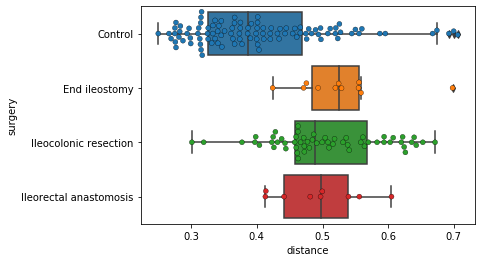

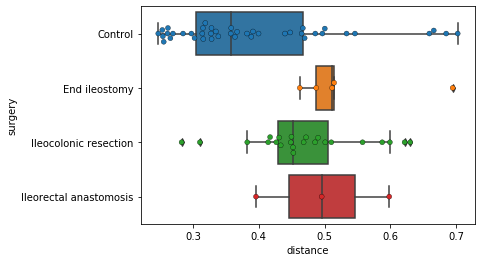

In [22]:
# queries for controls and cases ... Queries ... get it?
qontrol = 'category_1 == "cd" and category_2 == "Control"'
qases = 'category_1 == "cd" and category_2 != "Control"'

for all_samples in (True, False):
    (controls, cases), (u, p), w_stats, variables = compare_samples(qontrol, qases, mf, dm,
                                                                    table, all_samples=all_samples)
    # plot_comparisons(controls, cases, u, p, w_stats, variables, feature_metadata, table)
    variables['surgery'] = mf.loc[variables.index]['category_2']
    variables.sort_values(['surgery'], inplace=True)

    plt.figure()
    sns.boxplot(y='surgery', x='distance', data=variables)
    sns.swarmplot(y='surgery', x='distance', data=variables, edgecolor='black', linewidth=0.3)

# Crohn's disease

This section only needs to consider the stratification given by `category_2`.

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.05960752502073131 and the largest is 2.4622826782183975.
  RuntimeWarning
/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't

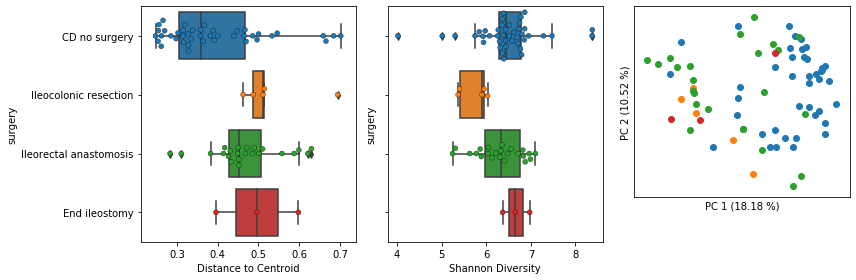

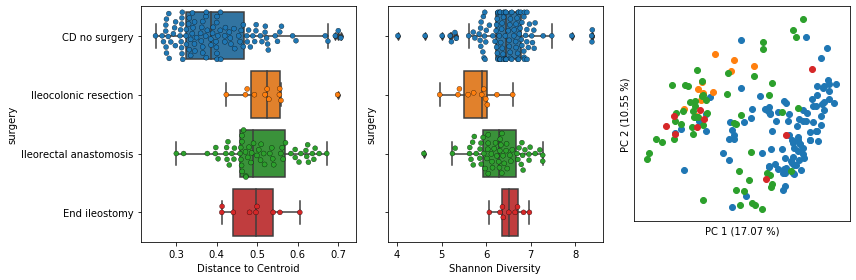

In [23]:
# queries for controls and cases ... Queries ... get it?
qontrol = 'category_1 == "cd" and category_2 == "Control"'
qases = 'category_1 == "cd" and category_2 != "Control"'

for all_samples in (False, True):
    (controls, cases), (u, p), w_stats, variables = compare_samples(qontrol, qases, mf, dm, table,
                                                                    all_samples=all_samples)

    variables['surgery'] = mf.loc[variables.index]['category_2']

    variables.sort_values(['surgery'], inplace=True)
    
    # as per Brigid's request
    #variables.surgery.replace({'Control': 'CD no surgery'}, inplace=True)
    #order = ['CD no surgery', 'Ileocolonic resection', 'Ileorectal anastomosis', 'End ileostomy']

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    ax = axes[0]
    sns.swarmplot(y='surgery', x='distance', data=variables, ax=ax, edgecolor='black', linewidth=0.3)
    sns.boxplot(y='surgery', x='distance', data=variables, ax=ax)
    ax.set_xlabel('Distance to Centroid')
    ax.set_yticklabels(['CD no surgery', 'Ileocolonic resection', 'Ileorectal anastomosis', 'End ileostomy'])
    
    ax = axes[1]
    sns.swarmplot(y='surgery', x='alpha', data=variables, ax=ax, edgecolor='black', linewidth=0.3)
    sns.boxplot(y='surgery', x='alpha', data=variables, ax=ax)
    ax.set_yticklabels([])
    ax.set_xlabel('Shannon Diversity')


    pc = skbio.stats.ordination.pcoa(dm.filter(cases + controls))

    variables['PC 1'] = pc.samples['PC1']
    variables['PC 2'] = pc.samples['PC2']

    ax = axes[2]
    for cat, _data in variables.groupby('surgery'):
        ax.scatter(x='PC 1', y='PC 2', data=_data, label=cat)
        ax.set_xlabel('PC 1 (%.2f %%)' % (pc.proportion_explained[0] * 100))
        ax.set_ylabel('PC 2 (%.2f %%)' % (pc.proportion_explained[1] * 100))

    ax.set_aspect('equal', adjustable='box', anchor='NW')
    ax.set_xticks([],[])
    ax.set_yticks([],[])

    fig.tight_layout()

# Ulcerative Colitis Analysis

This section needs to consider the stratification for `category_2` and for `category_3`.

## `category_2`

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.040508531912181345 and the largest is 2.333744934330025.
  RuntimeWarning
/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't

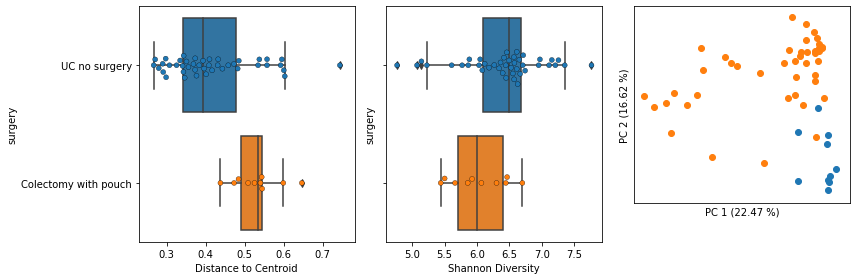

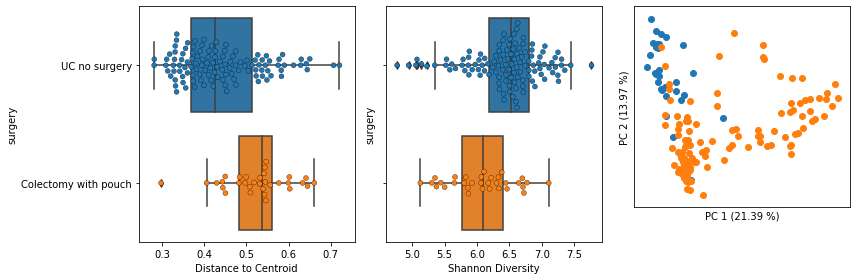

In [24]:
# queries for controls and cases ... Queries ... get it?
qontrol = 'category_1 == "uc" and category_2 == "Control"'
qases = 'category_1 == "uc" and category_2 != "Control"'


for all_samples in (False, True):
    (controls, cases), (u, p), w_stats, variables = compare_samples(qontrol, qases, mf, dm, table,
                                                                    all_samples=all_samples)

    variables['surgery'] = mf.loc[variables.index]['category_2']
    variables.sort_values(['surgery'], inplace=True, ascending=False)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    ax = axes[0]
    sns.swarmplot(y='surgery', x='distance', data=variables, ax=ax, edgecolor='black', linewidth=0.3)
    sns.boxplot(y='surgery', x='distance', data=variables, ax=ax)
    ax.set_xlabel('Distance to Centroid')
    ax.set_yticklabels(['UC no surgery', 'Colectomy with pouch'])

    ax = axes[1]
    sns.swarmplot(y='surgery', x='alpha', data=variables, ax=ax, edgecolor='black', linewidth=0.3)
    sns.boxplot(y='surgery', x='alpha', data=variables, ax=ax)
    ax.set_yticklabels([])
    ax.set_xlabel('Shannon Diversity')


    pc = skbio.stats.ordination.pcoa(dm.filter(cases + controls))

    variables['PC 1'] = pc.samples['PC1']
    variables['PC 2'] = pc.samples['PC2']

    ax = axes[2]
    for cat, _data in variables.groupby('surgery'):
        ax.scatter(x='PC 1', y='PC 2', data=_data, label=cat)
        ax.set_xlabel('PC 1 (%.2f %%)' % (pc.proportion_explained[0] * 100))
        ax.set_ylabel('PC 2 (%.2f %%)' % (pc.proportion_explained[1] * 100))

    ax.set_aspect('equal', adjustable='box', anchor='NW')
    ax.set_xticks([],[])
    ax.set_yticks([],[])

    fig.tight_layout()

## `category_3`

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.040508531912181345 and the largest is 2.333744934330025.
  RuntimeWarning
/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't

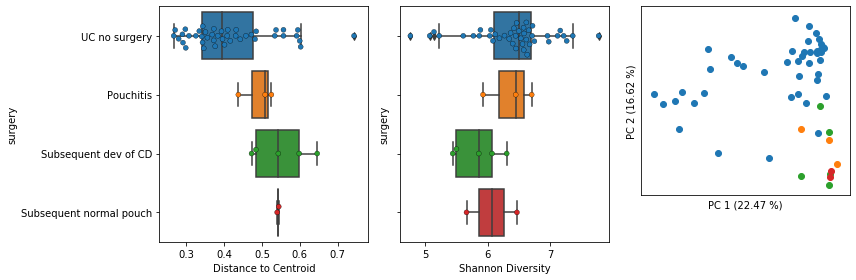

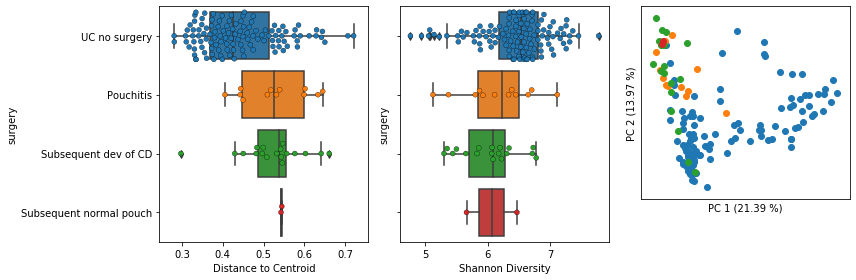

In [12]:
# queries for controls and cases ... Queries ... get it?
qontrol = 'category_1 == "uc" and category_2 == "Control"'
qases = 'category_1 == "uc" and category_2 != "Control"'


for all_samples in (False, True):
    (controls, cases), (u, p), w_stats, variables = compare_samples(qontrol, qases, mf, dm, table,
                                                                    all_samples=all_samples)

    variables['surgery'] = mf.loc[variables.index]['category_3']
    variables.sort_values(['surgery'], inplace=True)    

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    ax = axes[0]
    sns.swarmplot(y='surgery', x='distance', data=variables, ax=ax, edgecolor='black', linewidth=0.3)
    sns.boxplot(y='surgery', x='distance', data=variables, ax=ax)
    ax.set_xlabel('Distance to Centroid')
    ax.set_yticklabels(['UC no surgery', 'Pouchitis', 'Subsequent dev of CD', 'Subsequent normal pouch'])

    ax = axes[1]
    sns.swarmplot(y='surgery', x='alpha', data=variables, ax=ax, edgecolor='black', linewidth=0.3)
    sns.boxplot(y='surgery', x='alpha', data=variables, ax=ax)
    ax.set_yticklabels([])
    ax.set_xlabel('Shannon Diversity')


    pc = skbio.stats.ordination.pcoa(dm.filter(cases + controls))

    variables['PC 1'] = pc.samples['PC1']
    variables['PC 2'] = pc.samples['PC2']

    ax = axes[2]
    for cat, _data in variables.groupby('surgery'):
        ax.scatter(x='PC 1', y='PC 2', data=_data, label=cat)
        ax.set_xlabel('PC 1 (%.2f %%)' % (pc.proportion_explained[0] * 100))
        ax.set_ylabel('PC 2 (%.2f %%)' % (pc.proportion_explained[1] * 100))

    ax.set_aspect('equal', adjustable='box', anchor='NW')
    ax.set_xticks([],[])
    ax.set_yticks([],[])

    fig.tight_layout()

# Make a boxplot of samples split by ibd subtype and whether or not they have surgery

In [9]:
mf['category_1.5'] = ''

mf.loc[mf.query('category_2 == "Control"').index, 'category_1.5'] = 'No Surgery'
mf.loc[mf.query('category_2 != "Control"').index, 'category_1.5'] = 'Surgery'

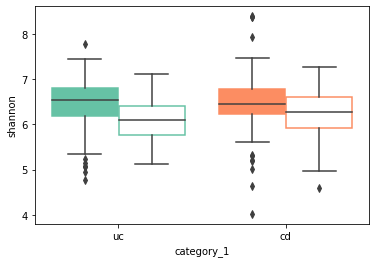

In [27]:
colors = {
    'Surgery': '#fc8d62',
    'No surgery': '#66c2a5',
}

fig, ax = plt.subplots()

sns.boxplot(x='category_1', y='shannon', hue='category_1.5', data=mf, order=['uc', 'cd'],
            hue_order=['No Surgery', 'Surgery'], ax=ax)

for i, color in enumerate(['#66c2a5', '#66c2a5', '#fc8d62', '#fc8d62']):
    
    if ((i + 1) % 2) == 0:
        ax.artists[i].set_facecolor('white')
        ax.artists[i].set_edgecolor(color)
    else:
        ax.artists[i].set_color(color)
ax.get_legend().set_visible(False)

fig.savefig('shannon.surgery-vs-nosurgery.pdf')

### Comparisons of UC surgery vs UC no surgery (without stratifying)

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.038732133471879315 and the largest is 2.8164810391493234.
  RuntimeWarning
/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/seaborn/categorical.py:410: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
W1028 12:42:56.696207 4659054016 legend.py:1282] No handles with labels found to put in legend.
/Users/yoshikivazquezbaeza/mini

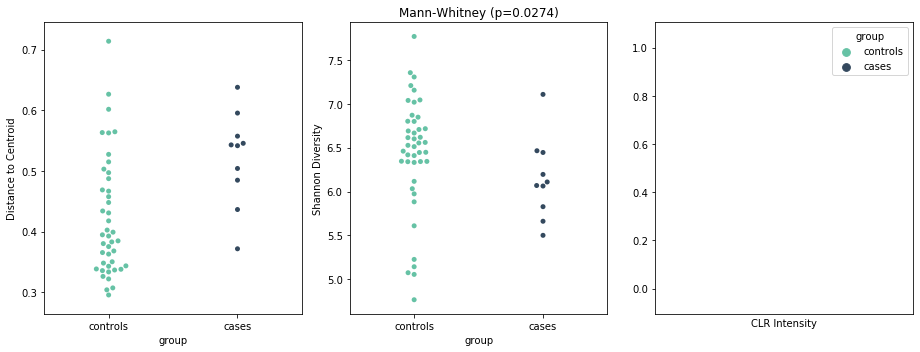

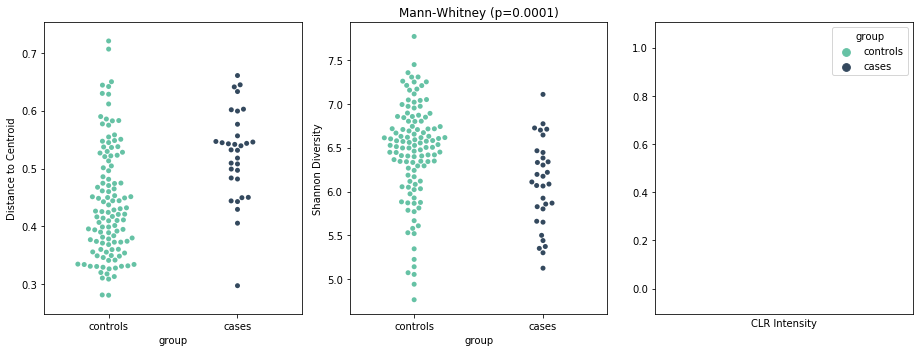

In [19]:
# queries for controls and cases ... Queries ... get it?
qontrol = 'category_1 == "uc" and category_2 == "Control"'
qases = 'category_1 == "uc" and category_2 != "Control"'

for all_samples in (False, True):
    (controls, cases), (u, p), w_stats, variables = compare_samples(qontrol, qases, mf, dm, table,
                                                                    all_samples=all_samples)
    plot_comparisons(controls, cases, u, p, w_stats, variables, feature_metadata, table)

### Comparisons of CD surgery vs CD no surgery (without stratifying)

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.04504721060652713 and the largest is 2.2769726814776305.
  RuntimeWarning
/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/seaborn/categorical.py:410: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
W1028 12:43:36.871034 4659054016 legend.py:1282] No handles with labels found to put in legend.
/Users/yoshikivazquezbaeza/minic

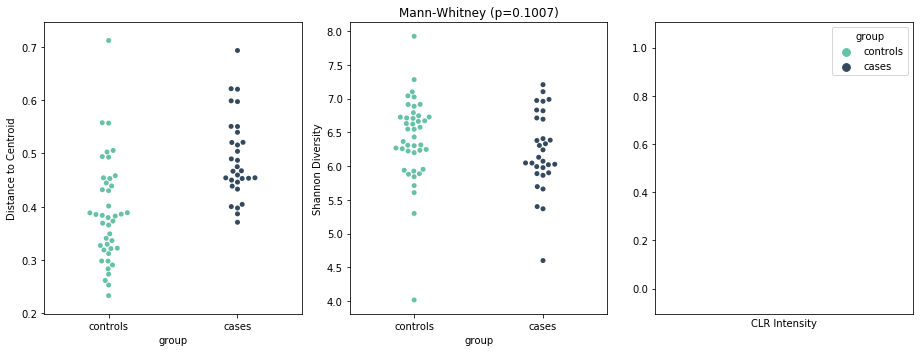

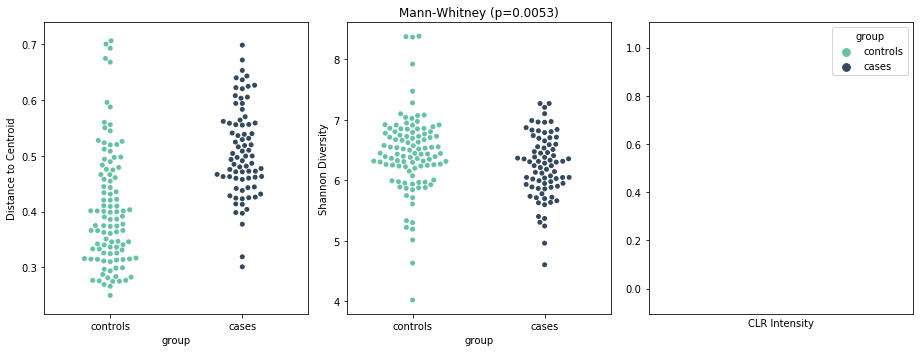

In [20]:
# queries for controls and cases ... Queries ... get it?
qontrol = 'category_1 == "cd" and category_2 == "Control"'
qases = 'category_1 == "cd" and category_2 != "Control"'

for all_samples in (False, True):
    (controls, cases), (u, p), w_stats, variables = compare_samples(qontrol, qases, mf, dm, table,
                                                                    all_samples=all_samples)
    plot_comparisons(controls, cases, u, p, w_stats, variables, feature_metadata, table)

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.038732133471879315 and the largest is 2.8164810391493234.
  RuntimeWarning
/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/seaborn/categorical.py:410: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
W1028 12:42:56.696207 4659054016 legend.py:1282] No handles with labels found to put in legend.
/Users/yoshikivazquezbaeza/mini

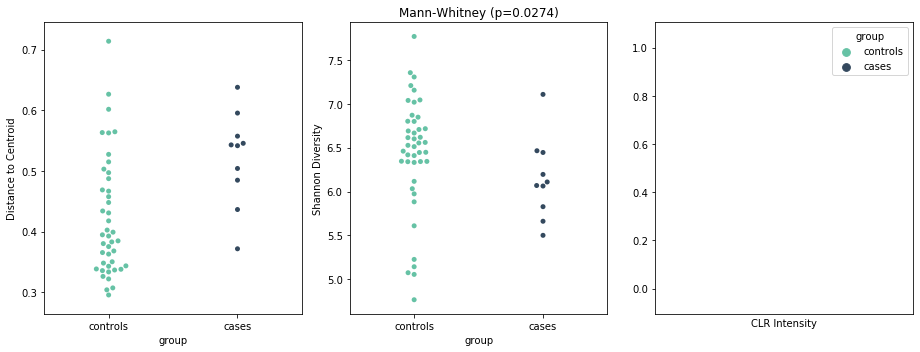

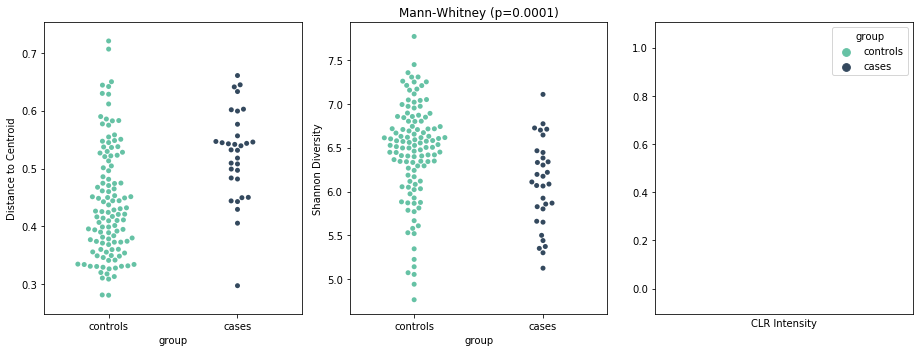

In [19]:
# queries for controls and cases ... Queries ... get it?
qontrol = 'category_1 == "uc" and category_2 == "Control"'
qases = 'category_1 == "uc" and category_2 != "Control"'

for all_samples in (False, True):
    (controls, cases), (u, p), w_stats, variables = compare_samples(qontrol, qases, mf, dm, table,
                                                                    all_samples=all_samples)
    plot_comparisons(controls, cases, u, p, w_stats, variables, feature_metadata, table)